* This notebook was made to evaluate mean current (only forced by river flow) during low river flow period by comparing with codar data.

In [1]:
%matplotlib inline
from IPython.core.display import Image
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import scipy.io as sio
import datetime
from salishsea_tools import (viz_tools,tidetools,nc_tools)
import matplotlib.gridspec as gridspec
import numpy.ma as ma
import os
import codar

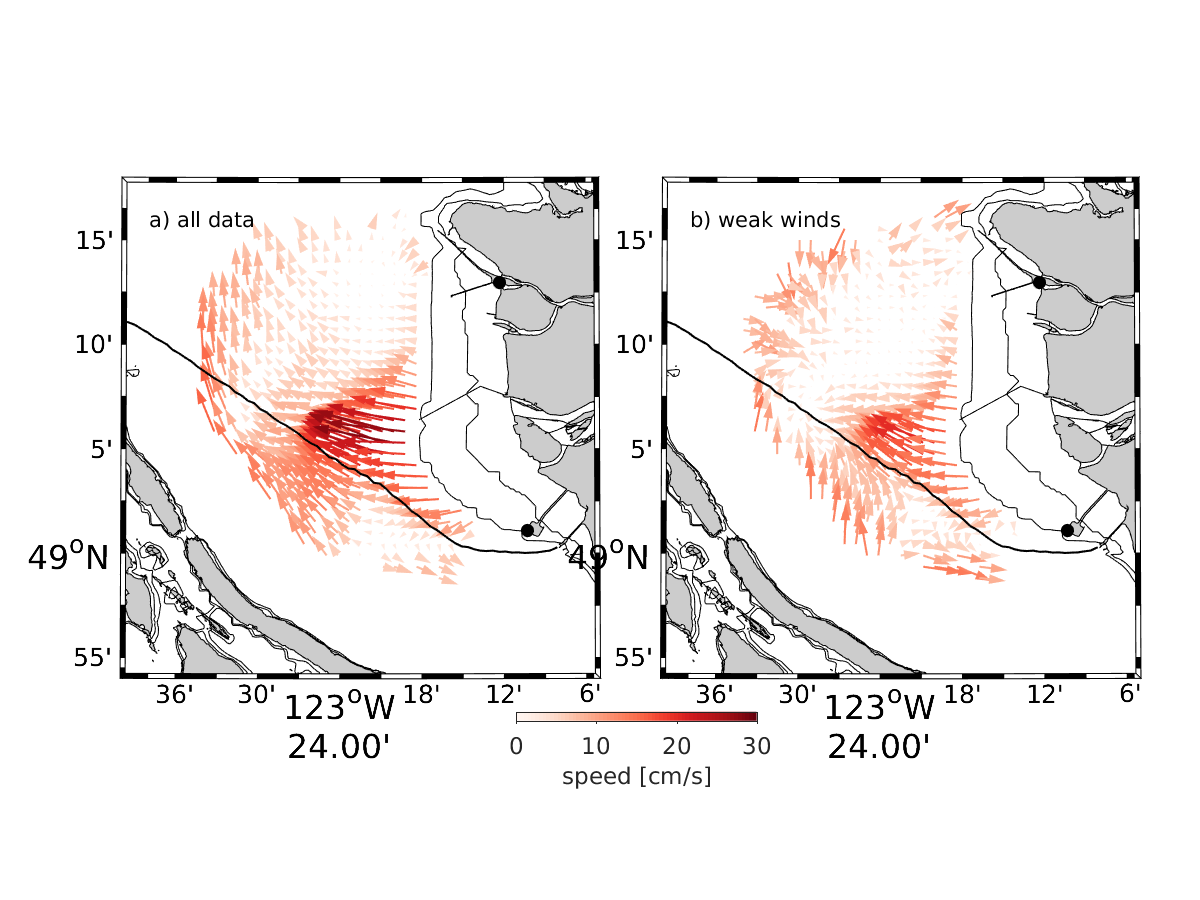

In [2]:
Image(filename='/ocean/jieliu/research/meopar/surface current/average_CODAR_Sep_Oct_2014.png')

In [3]:
## load data
codar_data = sio.loadmat('/ocean/jieliu/research/meopar/surface current/SoG_radar_totals.mat')
t = codar_data['mtime']
lat_codar = codar_data['glat']
lon_codar = codar_data['glon']
u = codar_data['u']
v = codar_data['v']

In [4]:
## load different bathys
grid2 = nc.Dataset('/ocean/jieliu/research/meopar/nemo-forcing/grid/bathy_meter_SalishSea2.nc')
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X={};Y={};bathy={};grids = [grid2,grid6]
for grid in grids:
    X[grid] = grid.variables['nav_lon'][:, :]
    Y[grid] = grid.variables['nav_lat'][:, :]
    bathy[grid] = grid.variables['Bathymetry'][:, :]

# Research Questions:

* 1) During which time period would i like to take a look at the mean river flow of model results? For a month, a week??
* 2) Based on the all data and weak wind case, should I also average over the same period as what I did for the codar data? Or use the same mean current of the codar data? The essence is that what does "mean current" mean in my case? Should I make them in the same period?
* 3) By evaluating the mean current field of model result, I hope to get some insights about explaining the mouth region is saltier in the long river simulation. I don't know if this might help or not...

In [5]:
run_low = datetime.datetime(2015,10,1,0);
run_up = datetime.datetime(2015,11,1,0);

In [6]:
#subset
ist=1
ien=398
jst=1
jen=898
x=np.arange(ist,ien)
y=np.arange(jst,jen)
st=3

In [117]:
def plot_both(run_low,run_up, cmin=0,cmax = 0.3 ):
    fig = plt.figure(figsize=(42,12))
    gs = gridspec.GridSpec(1, 3,width_ratios=[1, 1,1])  
    gs.update(hspace=0.15, wspace=0.1)
    ##plot codar quiver
    ax0 = fig.add_subplot(gs[0,0])
    viz_tools.plot_coastline(ax0, grid6, coords = 'map')
    viz_tools.plot_coastline(ax0, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
    viz_tools.plot_land_mask(ax0,grid6,coords='map',xslice=x,yslice=y,color='burlywood')
    ax0.plot(-123-np.array([18.2,13.7,12])/60.,49+np.array([6.4,8,7.6])/60.,'-k',lw=2,color='SpringGreen')
    
    p_low, ind_low = codar.python_time(run_low,t); p_up, ind_up = codar.python_time(run_up,t)
    sta = np.zeros((46,36));
    for j in range(46):
        for i in range(36): ## count of nan
            sta[j,i] = 100*np.sum(np.isnan(u[j,i,ind_low:ind_up]))/(ind_up-ind_low)
    sta[sta<50] = 0 ##selet good data
    sta[sta>=50] = 1
    uu = np.ma.masked_array(u[:,:,0], sta)
    mask = uu.mask ## mask array
    ## mask is equal to mask array, broadcast here!
    mask_expand = np.expand_dims(mask, axis=2)
    mask_expand = mask_expand + np.zeros(u.shape) #broadcasting here!
    #Apply mask
    u_mask = np.ma.masked_array(u,mask=mask_expand)
    v_mask = np.ma.masked_array(v,mask=mask_expand)
    
    u_new = np.nanmean(u_mask[:,:,ind_low:ind_up]/100,axis = 2); ##average the whole time period in a month
    v_new = np.nanmean(v_mask[:,:,ind_low:ind_up]/100,axis = 2)
    ## plot codar
    mesh=ax0.pcolormesh(lon_codar,lat_codar, ma.masked_invalid(np.sqrt(u_new**2+v_new**2)), cmap='bwr', \
                        vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(mesh, ax=ax0)
    cbar.set_label('Total Velocity[m/s]', fontsize = 20)
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  
    quiver = ax0.quiver(lon_codar, lat_codar,u_new,v_new, pivot='mid', scale = 2,width=0.005, color='black')
    ax0.quiverkey(quiver,-123.1,49.25, 0.3, '0.3 m/s',coordinates='data', color='black', labelcolor='black',
                fontproperties = {'size': '15'})
    print ('mean flow of codar is '+str(np.nanmean(np.sqrt(u_new**2+v_new**2)))+' m/s')
    ## plot modelled surface currents
    ax1 = fig.add_subplot(gs[0,1]); ax2 = fig.add_subplot(gs[0,2])
    u_grid = nc.Dataset('mean_U.nc','r'); v_grid = nc.Dataset('mean_V.nc','r'); 
    u_m = {};v_m = {};U_m ={};V_m={};
    #for ax,grid in zip([ax1,ax2],grids):
    u_m[grid2] =u_grid.variables['vozocrtx'][0, 0,jst-1:jen,ist-1:ien]
    v_m[grid2] =v_grid.variables['vomecrty'][0, 0,jst-1:jen,ist-1:ien]
    ##unstagger u v
    U_m[grid2],V_m[grid2] = viz_tools.unstagger(u_m[grid2],v_m[grid2])
    #rotate
    theta = np.pi*29/180
    U_m[grid2] = U_m[grid2]*np.cos(theta) - V_m[grid2]*np.sin(theta)
    V_m[grid2] = U_m[grid2]*np.sin(theta) +V_m[grid2]*np.cos(theta)
    ##mask
    U_m[grid2]=np.ma.masked_values(U_m[grid2],0)
    V_m[grid2]=np.ma.masked_values(V_m[grid2],0)

    lon = X[grid2][jst:jen,ist:ien]
    lat = Y[grid2][jst:jen,ist:ien]
    mesh=ax1.pcolormesh(lon[380:460,240:320], lat[380:460,240:320], \
            np.sqrt(U_m[grid2][380:460,240:320]**2+V_m[grid2][380:460,240:320]**2), \
                        cmap='bwr', vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(mesh, ax=ax1)
    cbar.set_label('Total Velocity[m/s]', fontsize = 20)
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  
    #quiver = ax1.quiver(lon[380:460,240:320][::st,::st], lat[380:460,240:320][::st,::st],\
                        #U_m[grid2][380:460,240:320][ ::st, ::st], V_m[grid2][380:460,240:320][::st,::st],\
                        #pivot='mid',scale=2,width=0.005, color='black' )
    
    quiver = ax1.quiver(lon[jj,ii], lat[jj,ii],\
                        U_m[grid2][jj,ii], V_m[grid2][jj,ii],\
                        pivot='mid',scale=2,width=0.005, color='black' )
    ax1.quiverkey(quiver,-123.1,49.25, 0.3, '0.3 m/s', coordinates='data', color='black', labelcolor='black',\
                fontproperties = {'size': '15'})
    viz_tools.plot_land_mask(ax1,grid2,coords='map',xslice=x,yslice=y,color='burlywood')
    viz_tools.plot_coastline(ax1, grid2, coords = 'map', isobath = 5,color = 'DarkViolet')
    codar.statistics_currents_mod(lon,lat,np.nanmin(lon_codar),np.nanmax(lon_codar),\
                 np.nanmin(lat_codar),np.nanmax(lat_codar), U_m[grid2], V_m[grid2])## mean modelled flow

    for ax in [ax0,ax1,ax2]:
        ax.set_xlim([-123.7,-123])
        ax.set_ylim([48.8,49.3])
        plt.setp(ax.get_xticklabels(), fontsize=20)
        plt.setp(ax.get_yticklabels(), fontsize=20)
        ax.set_xlabel('Longitude',fontsize=20)
        ax.set_ylabel('Latitude',fontsize=20)
        ax.set_xticks([-123.6, -123.4, -123.2,-123])
        ax.set_xticklabels([-123.6, -123.4, -123.2,-123])

    return fig

In [23]:
p_low, ind_low = codar.python_time(run_low,t); p_up, ind_up = codar.python_time(run_up,t)
sta = np.zeros((46,36));
for j in range(46):
    for i in range(36): ## count of nan
        sta[j,i] = 100*np.sum(np.isnan(u[j,i,ind_low:ind_up]))/(ind_up-ind_low)
sta[sta<50] = 0 ##selet good data
sta[sta>=50] = 1
uu = np.ma.masked_array(u[:,:,0], sta)
mask = uu.mask ## mask array
## mask is equal to mask array, broadcast here!
mask_expand = np.expand_dims(mask, axis=2)
mask_expand = mask_expand + np.zeros(u.shape) #broadcasting here!
#Apply mask
u_mask = np.ma.masked_array(u,mask=mask_expand)
v_mask = np.ma.masked_array(v,mask=mask_expand)
    
u_new = np.nanmean(u_mask[:,:,ind_low:ind_up]/100,axis = 2); ##average the whole time period in a month
v_new = np.nanmean(v_mask[:,:,ind_low:ind_up]/100,axis = 2)
mm = ma.masked_invalid(np.sqrt(u_new**2+v_new**2))


In [110]:
    u_grid = nc.Dataset('mean_U.nc','r'); v_grid = nc.Dataset('mean_V.nc','r'); 
    u_m = {};v_m = {};U_m ={};V_m={};
    #for ax,grid in zip([ax1,ax2],grids):
    u_m[grid2] =u_grid.variables['vozocrtx'][0, 0,jst-1:jen,ist-1:ien]
    v_m[grid2] =v_grid.variables['vomecrty'][0, 0,jst-1:jen,ist-1:ien]
    ##unstagger u v
    U_m[grid2],V_m[grid2] = viz_tools.unstagger(u_m[grid2],v_m[grid2])
    #rotate
    theta = np.pi*29/180
    U_m[grid2] = U_m[grid2]*np.cos(theta) - V_m[grid2]*np.sin(theta)
    V_m[grid2] = U_m[grid2]*np.sin(theta) +V_m[grid2]*np.cos(theta)
    ##mask
    U_m[grid2]=np.ma.masked_values(U_m[grid2],0)
    V_m[grid2]=np.ma.masked_values(V_m[grid2],0)

In [104]:
i_inds = [] ## indices to apply for model results
j_inds = []
for j in range(46):
    for i in range(36):
        if mm[j,i] != 1e+20:
            [jj,ii] = tidetools.find_closest_model_point(lon_codar[j,i],lat_codar[j,i],X[grid6],Y[grid6],bathy[grid6],\
                                                         lat_tol=0.0020)
            j_inds.append(jj)
            i_inds.append(ii)

In [120]:
jj = np.array(j_inds)
ii = np.array(i_inds)
mm

masked_array(data =
 [[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]],
             mask =
 [[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]],
       fill_value = 1e+20)

In [122]:
U_m[grid2].shape

(897, 397)

# Method2

In [129]:
lon = X[grid2][jst:jen,ist:ien]
lat = Y[grid2][jst:jen,ist:ien]
#u_mod = ma.masked_where(mm==1e+20,U_m[grid2])
#for j, i in zip(jj,ii):
u_mod = ma.masked_where(jj & ii,U_m[grid2][jj,ii])

In [157]:
## mask the whole array
lon = ma.masked_array(lon, mask = True)
np.array(lon[~lon.mask] )

array([], dtype=bool)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


mean flow of codar is 0.0796759634364 m/s
modelled mean flow is 0.0696035161492 m/s

/home/jieliu/anaconda3/lib/python3.4/site-packages/numpy/ma/core.py:4085: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


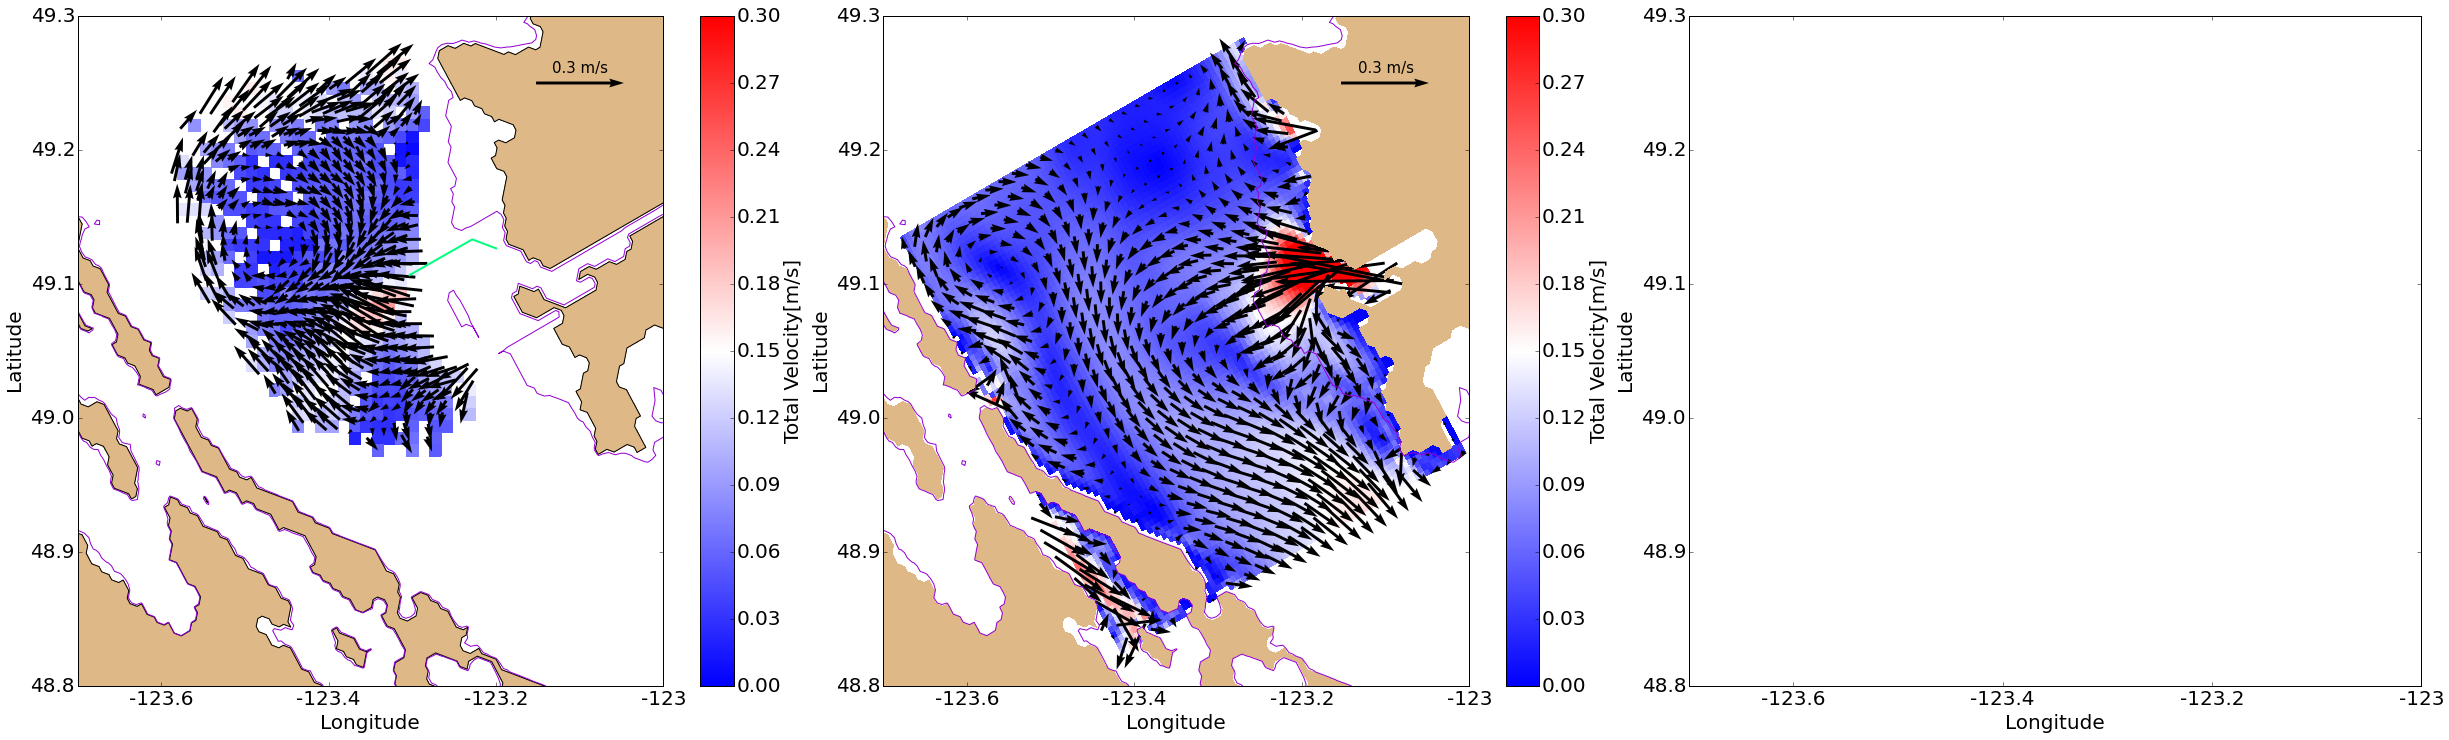

In [14]:
fig = plot_both(run_low,run_up)

# Test domain of CODAR.nc to run model with bathy6

In [11]:
a = nc.Dataset('CODAR.nc')
alon = a.variables['nav_lon']
alat = a.variables['nav_lat']
au = a.variables['vozocrtx']

In [12]:
j,i = tidetools.find_closest_model_point(alon[-1,-1],alat[-1,-1],X[grid6],Y[grid6],bathy[grid6])
print (j,i)

459 318


In [13]:
c = nc.Dataset('mean_U.nc')
cu = c.variables['vozocrtx']
clon = c.variables['nav_lon']
clat = c.variables['nav_lat']

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


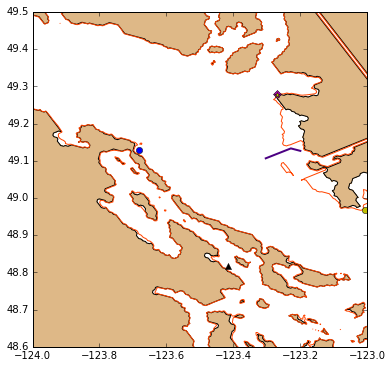

In [14]:
fig,ax = plt.subplots(1,1,figsize = (6,6))
##plot codar quiver
viz_tools.plot_coastline(ax, grid6, coords = 'map')
viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'OrangeRed')
viz_tools.plot_land_mask(ax,grid6,coords='map',xslice=x,yslice=y,color='burlywood')
ax.plot(-123-np.array([18.2,13.7,12])/60.,49+np.array([6.4,8,7.6])/60.,'-k',lw=2,color='Indigo')
ax.set_xlim([-124,-123])
ax.set_ylim([48.6,49.5])
ax.plot(alon[-1,0],alat[-1,0],'ob') ## (459,240)
ax.plot(alon[0,0],alat[0,0],'^k') ## (380, 240)
ax.plot(alon[0,-1],alat[0,-1],'oy') ##(380,319)
ax.plot(clon[459,319],clat[459,319],'mD') ## (459, 318)
ax.plot(alon[-1,-1],alat[-1,-1],'y*') ##(459, 319)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


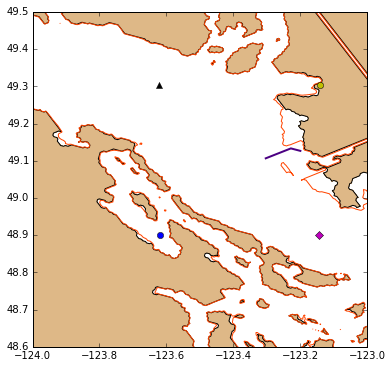

In [15]:
fig,ax = plt.subplots(1,1,figsize = (6,6))
##plot codar quiver
viz_tools.plot_coastline(ax, grid6, coords = 'map')
viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'OrangeRed')
viz_tools.plot_land_mask(ax,grid6,coords='map',xslice=x,yslice=y,color='burlywood')
ax.plot(-123-np.array([18.2,13.7,12])/60.,49+np.array([6.4,8,7.6])/60.,'-k',lw=2,color='Indigo')
ax.set_xlim([-124,-123])
ax.set_ylim([48.6,49.5])
ax.plot(lon_codar[-1,0],lat_codar[-1,0],'ob')
ax.plot(lon_codar[0,0],lat_codar[0,0],'^k')
ax.plot(lon_codar[0,-1],lat_codar[0,-1],'oy')
ax.plot(lon_codar[-1,-1],lat_codar[-1,-1],'mD')